# load function

In [6]:
### v6【load function for find gap candidate】 

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import math

def clean_second_data(ToA):  # clean ToA data to get waiting time
    ToA = np.sort(ToA)
    n = np.delete(np.array(range(len(ToA))), -1)  # delet last one
    wt=[]
    for i in n:
        wt = np.append(wt, ((ToA[i+1] - ToA[i])))  # waiting time, in second
   
    wt = wt[(wt_small< wt) & (wt < (wt_big * 10))]
    wt = wt[np.argsort(wt)]
    return wt  # all wt, wt in searching window,  wt for checking



def clean_mjd_data(ToA):  # clean ToA data to get waiting time
    ToA = np.sort(ToA)
    n = np.delete(np.array(range(len(ToA))), -1)  # delet last one
    
    wt=[]
    for i in n:
        wt = np.append(wt, ((ToA[i+1] - ToA[i]) * 24*3600))  # waiting time, in second
    wt = np.delete(wt, wt>3600)  # delet wt too big which from two observation
    wt = wt[(wt_small< wt) & (wt < (wt_big * 10))]
    wt = wt[np.argsort(wt)]
    return wt



def first_gap_search(wt):  # find gap_candidates allow r_gap
    cand_gap=[]
    for start_wt in range(len(wt) -1 ):
        max_gap = wt[start_wt+1] - wt[start_wt]   # 把每个空档都当成，潜在最大的周期空档候选体
        min_on = wt[start_wt]
        if (min_on / (max_gap + 2 * wt[start_wt])) < duty_cycle:
            cand_gap = np.append(cand_gap, int(start_wt))
    cand_gap = list(map(int, cand_gap)) ## Convert to int
    return cand_gap



def parameter_space(start_wt):  # get parameter_space in a candidate gap_1
    gap_off = wt[start_wt+1];  gap_on = wt[start_wt]
    max_on = symbols('x')
    max_on = solve((max_on)/(max_on + gap_off) - duty_cycle, max_on) 
    max_on = max_on[0]
    list_on = np.linspace(gap_on, float(max_on), num=50)  #步长设置
    
    on_off_list = np.array([0, 0])
    for on in list_on:
        min_off = symbols('x')
        min_off = solve((on) / (on + min_off) - duty_cycle, min_off)
        min_off = min_off[0]
        list_off = np.linspace(float(min_off), gap_off, num=20)  #
        
        on_off_list_temp = np.ones_like(list_off) * on
        on_off_list_temp = np.array(list(zip(on_off_list_temp, list_off)))
        on_off_list = np.vstack([on_off_list, on_off_list_temp])
        
    on_off_list = np.delete(on_off_list, 0,0)
    return on_off_list



def search_gap(gap_on, gap_off, gap_n):  # search gap_n 
    period = gap_off + gap_on
    error_extent = (gap_off - gap_on) * (error_rate * 0.5)  # 根据gap宽度和容错比率，计算出可以误差的大小

    start_gap_n = gap_on + (gap_n-1) * period 
    end_gap_n = gap_off + (gap_n-1) * period
    check_list = [num for num in wt if (start_gap_n + error_extent)  <= num <= (end_gap_n - error_extent)]

    if not any(check_list):
        return gap_on, gap_off
    else:
        return False, False



def main_search(cand_gap):  # main for gap search
    if search_n_gap < 2:
        print("search_n_gap too small")
        exit()
    
    search_range = list(range(search_n_gap+1)); del search_range[0:2]  # 要搜寻的第n个gap列表，如2， 3， 4
    
    cand_gap_all = []
    for start_wt in cand_gap:
        ## creat empty dictionary
        cand_gap_list=[]
        for i in search_range:
            cand_gap_list.append(np.zeros([2,2]))
        gap_dict = dict(zip(search_range, cand_gap_list))
        
        start_end_list = parameter_space(start_wt)  # get parameter_space, and write it into cand_gap_1
        gap_dict[1] = start_end_list
            
        for gap_n in search_range:
            
            if not np.any(gap_dict[gap_n-1]):  # if last gap have no candidate
                print('break', gap_n-1, 'th gap did not pass')   # print those didn't pass
                break
                
            for i in range(len(gap_dict[gap_n-1])):
                start_gap1 , end_gap1 = gap_dict[gap_n-1][i]
                gap_dict[gap_n] = np.append(gap_dict[gap_n], [search_gap(start_gap1, end_gap1, gap_n)], axis=0)  # 对第n个gap进行检验，并记录结果
            gap_dict[gap_n] = [i for i in gap_dict[gap_n] if all(i)]  # clean zero line
        cand_gap_all.append(gap_dict)
    return cand_gap_all
    


def check_candidate(cand_gap_all):  # check candidate
    print('\n', len(cand_gap_all), ' # number of first gap candidate', '\n')  # how many candidate region
    
    for n_cand_gap in cand_gap_all:  # print candidate
        if np.any(n_cand_gap[search_n_gap]):
            print('W_on, W_off : ',n_cand_gap[search_n_gap][0], '# one example of candidate group', '\n')
        else:
            print('no candidate', '\n')
            
    
def log_plot(wt, nbin):  # log plot for waiting time
    logbins = np.logspace(np.log10(min(wt)), np.log10(max(wt)), nbin)
    plt.hist(wt, bins=logbins)
    plt.xscale('log')
    # plt.xlim(xlim[0], xlim[1])
    plt.xlabel('waiting time(s)', fontsize=14)
    plt.title('n_bursts: '+str(len(wt)), fontsize=14)
    plt.show();plt.clf()


### plot gap
def plot_gap():
    plt.rcParams["figure.figsize"] = (15,4)
    plt.xlabel("waiting time (s)", fontsize=15)
    p_gap = s_gap + e_gap
    plt.title(FRB_name + '\n' + "   begin_gap=" + str(round(s_gap, 4)) + ' s' + "   period=" + str(round(p_gap, 4)) + ' s' , fontsize=15)
    plt.yticks([])
    
    
    plot_n_gap_list = range(plot_n_gap)
    list_start_line = []; list_end_line = []
    for n in plot_n_gap_list:
        list_start_line.append(s_gap + n * p_gap)
        list_end_line.append(e_gap + n * p_gap)
    for i in range(len(list_start_line)):
        plt.axvspan(xmin=list_start_line[i], xmax=list_end_line[i], facecolor="b", alpha=0.2)
    
    ### plot wt
    xlim = [s_gap*0.1, (e_gap+ plot_n_gap_list[-1]*p_gap)*1.02]
    list_wt_line = [i for i in wt if xlim[0] < i < xlim[1]]
    for i in list_wt_line:
        plt.axvline(i, color ="k", ls="-", alpha=0.7, lw=0.7) 
    plt.xlim(xlim[0], xlim[1])
    
    plt.show()
    plt.clf()

# real data search

搜寻的源：FRB 220529、FRB 201124、FRB 121102、FRB 220912

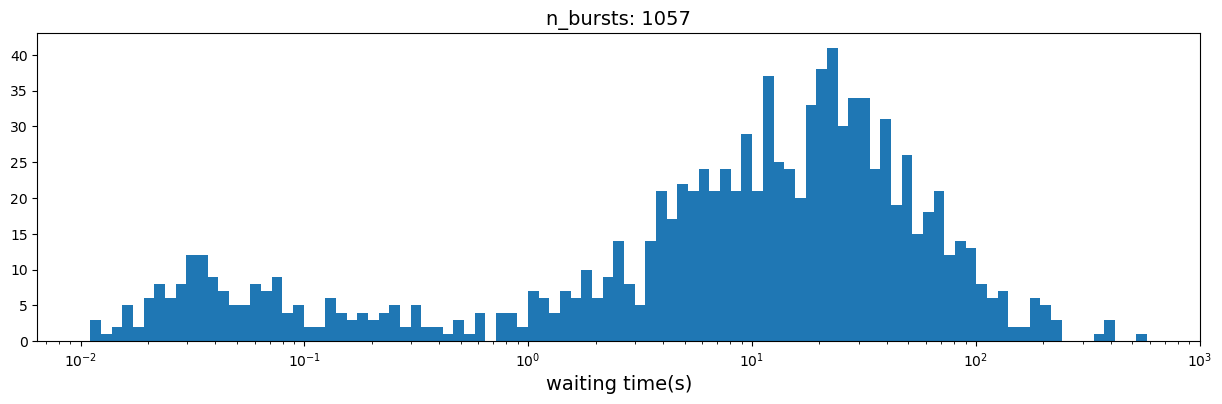


 2  # number of first gap candidate 

W_on, W_off :  [241.08148757 301.35185947] # one example of candidate group 

W_on, W_off :  [405.88300831 507.35376039] # one example of candidate group 



<Figure size 1500x400 with 0 Axes>

In [7]:
# test search, work

import os
import numpy as np


### load data
# file_address = './0-data/121102_nburst_1595.txt' 
# file_address = './0-data/FRB20220529_mjd_230319_nburst_1017.txt' 
# file_address = './0-data/201124A-202104-06_nburst_1863.txt' 
file_address = './0-data/FRB 20220912A.txt' 


with open(file_address, 'r') as file:
    ToA = file.read().split('\n')
    ToA = np.array(ToA).astype(float)
file.closed



## manual input
duty_cycle = 160  # max duty cycle angle degree
duty_cycle = duty_cycle / 360  # 转换为比率

search_n_gap = 6
error_rate = 0.1  # error in searching gap
wt_small = 1e-2  # lowest waiting_time for searching (second)
wt_big = 300
# wt_small = 1e-4  ;  wt_big = 500


## searching
wt = clean_mjd_data(ToA) # all wt, wt in searching window, wt for checking
log_plot(wt, 100)  # plot for check
cand_gap = first_gap_search(wt)
cand_gap_all = main_search(cand_gap)
check_candidate(cand_gap_all)

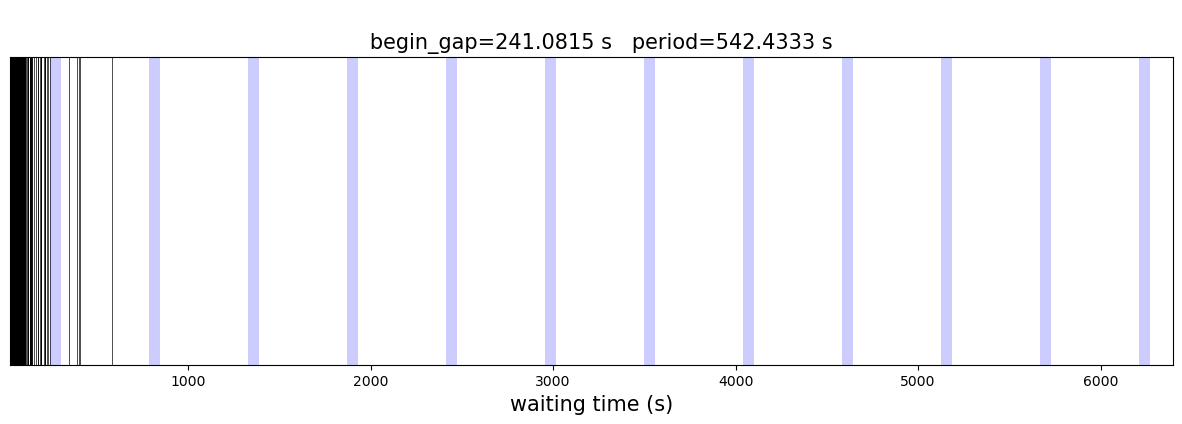

<Figure size 1500x400 with 0 Axes>

In [10]:
### plot cand_gap

l, m, n = 0, 5, 0
s_gap, e_gap = cand_gap_all[l][m][n]  # 第l个候选区间，第m个周期gap，第n个具体周期参数
# s_gap, e_gap = 0.5046705 , 0.71416542  # 手动输入
# s_gap, e_gap = wt[cand_gap[0]], wt[cand_gap[0]+1]  # 检查第一轮的候选体

plot_n_gap = 12
FRB_name = ''


plot_gap()

# simulated data search

In [214]:
### 【search】


## manual input
search_n_gap = 5
duty_cycle = 140  # max duty cycle angle degree
error_rate = 0.05  # error in searching gap

wt_small = 1e-1  # lowest waiting_time for searching (second)
wt_big = 100
duty_cycle = duty_cycle / 360


## load ToA
ToA = np.load('./0-data/simulate ToA.npy')


## searching
wt = clean_second_data(ToA) # all wt, wt in searching window, wt for checking
# log_plot(wt, 100)  # plot for check
cand_gap = first_gap_search(wt)
cand_gap_all = main_search(cand_gap)
check_candidate(cand_gap_all)


 1  # number of first gap candidate 

W_on, W_off :  [0.30261874 0.69612604] # one example of candidate group 



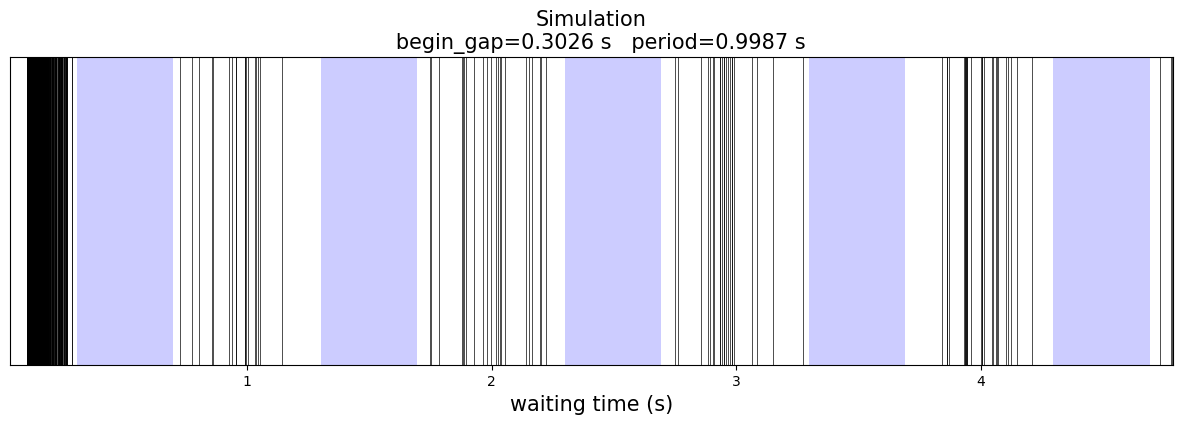

<Figure size 1500x400 with 0 Axes>

In [221]:
### plot cand_gap

l, m, n = 0, 5, 0
s_gap, e_gap = cand_gap_all[l][m][n]  # 第l个候选区间，第m个周期gap，第n个具体周期参数
# s_gap, e_gap = 0.5046705 , 0.71416542
plot_n_gap = 5
FRB_name = 'Simulation'


plot_gap()

In [51]:
%%time
###  gap search with energy threshold，

import pandas as pd
import re
import numpy as np


def clean_plot_txt(data):  # get ToA from plot.txt file
    data['TOA'] = data.iloc[:,0].str.extract(r'(?<=-obs\s)([\d.]+)')  # 取-obs后的ToA
    data['TOA'] = [str(l_to_b(x)) for x in data['TOA']]  # convert to barycentric time
    data['energy'] = data.iloc[:,0].str.extract(r'(?<=-snr\s)([\d.]+)')
    return data


def energy_threshold(data, th):
    data = data[data['SNR'].astype(float) > th]
    ToA = list(data['TOA'].astype(float))
    return ToA

### load ToA


def drop_multipeak(data):  # delete the summed head of multipeak
    mask = ~data['Burst'].str.contains('-', na=False)
    mask_2 = mask*False
    for n, i in enumerate(mask):
        try:
            if not mask[n+1] and mask[n]:  # locate multipeak
                mask_2[n] = True
        except:
            continue
    data = data.loc[~mask_2, :]  # delete multipeak
    return data


### 201124A data
data = pd.read_excel(io=r'../a-data/FRB 201124A arxiv 2210.03607.xlsx',sheet_name=0, 
                     header=0, usecols="A:L", nrows=1826)

# data = drop_multipeak(data)
data = data.loc[~ data['Burst'].str.contains('-', na=False), :]  # 去除Burst中有‘-’的

snr_th = 400
ToA = energy_threshold(data, snr_th)



### manual input
search_n_gap = 3
duty_cycle = 120  # max duty cycle angle degree
error_rate = 0.2  # error in searching gap

wt_small = 1e-4  # lowest waiting_time for searching (second)
wt_big = 500
duty_cycle = duty_cycle / 360; r_gap = 1 - 2 * duty_cycle  # r * P = min(off - on), setted according to pulsar
xlim = [0.00001, 2050]  # min(wt) and max(wt) 



### searching
wt_all, wt, wt_check = clean_data(ToA) # all wt, wt in searching window, wt for checking
cand_gap = first_gap_search(wt)
cand_gap_all = main_search(cand_gap)
check_candidate(cand_gap_all)


 3  # number of first gap candidate 

[0.00060475 0.00120951] # one example of candidate group 

[0.07819247 0.15638494] # one example of candidate group 

no candidate 

Wall time: 13.8 s
